# Task
This assignment assesses your ability to process hyperspectral imaging data, perform dimensionality reduction, and develop a machine learning model to predict mycotoxin levels (e.g., DON concentration) in corn samples.

## Problem Statement
You are provided with a compact hyperspectral dataset containing spectral reflectance data from corn samples across multiple wavelength bands. Your task is to:
- Preprocess the data (e.g., handle missing values, normalize features).
- Visualize spectral bands to explore data characteristics.
- Reduce dimensionality using PCA or t-SNE and interpret the results.
- Train a machine learning model (e.g., Random Forest, XGBoost, or a simple neural network) for regression.
- Evaluate the model and present actionable insights.

## Dataset Description
- Features: Spectral reflectance values across multiple wavelength bands (columns).
- Rows: Individual corn samples.
- Target Variable: DON concentration (continuous, for regression).


## Importing Libraries

In [ ]:
import pandas as pd
import joblib
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

## Data Exploration and Preprocessing

### Data Loading and Exploration

In [25]:
df = pd.read_csv('../data/data.csv')

print("First 5 rows of the dataframe:")
print(df.head().to_markdown(index=False, numalign="left", stralign="left"))

print("\nInformation about the dataframe:")
print(df.info())

print("\nMissing values in each column:")
print(df.isnull().sum())

First 5 rows of the dataframe:
| hsi_id         | 0        | 1        | 2        | 3        | 4        | 5        | 6        | 7        | 8        | 9        | 10       | 11       | 12       | 13       | 14       | 15       | 16       | 17       | 18       | 19       | 20       | 21       | 22       | 23       | 24       | 25       | 26       | 27       | 28       | 29       | 30       | 31       | 32       | 33       | 34       | 35       | 36       | 37       | 38       | 39       | 40       | 41       | 42       | 43       | 44       | 45       | 46       | 47       | 48       | 49       | 50       | 51       | 52       | 53       | 54       | 55       | 56       | 57       | 58       | 59       | 60       | 61       | 62       | 63       | 64       | 65       | 66       | 67       | 68       | 69       | 70       | 71       | 72       | 73       | 74       | 75       | 76       | 77       | 78       | 79       | 80       | 81       | 82       | 83       | 84       | 85       | 86  

### Data Preprocessing

In [26]:
X = df.drop(['hsi_id', 'vomitoxin_ppb'], axis=1)
y = df['vomitoxin_ppb']

feature_names = list(X.columns)
joblib.dump(feature_names, '../models/feature_names.joblib')  # Save using joblib


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nFirst 5 rows of the scaled features:")
print(X_scaled[:5])


First 5 rows of the scaled features:
[[-0.60295878 -0.96575088 -0.54309276 ... -0.49905519 -0.73814026
  -0.61907074]
 [-0.61156195 -0.83133055 -0.68354721 ... -0.76682669 -0.75912491
  -0.90419241]
 [-1.21086777 -1.52953722 -1.32806143 ... -1.47059948 -1.23164663
  -1.34439287]
 [ 0.57569326  0.7145586   0.63727    ...  0.07685931  0.31541073
  -0.0852677 ]
 [ 0.90061447  1.0228321   0.77298781 ...  0.68918152  0.42217839
   0.25605168]]


### Visualization of Sprectral Bands

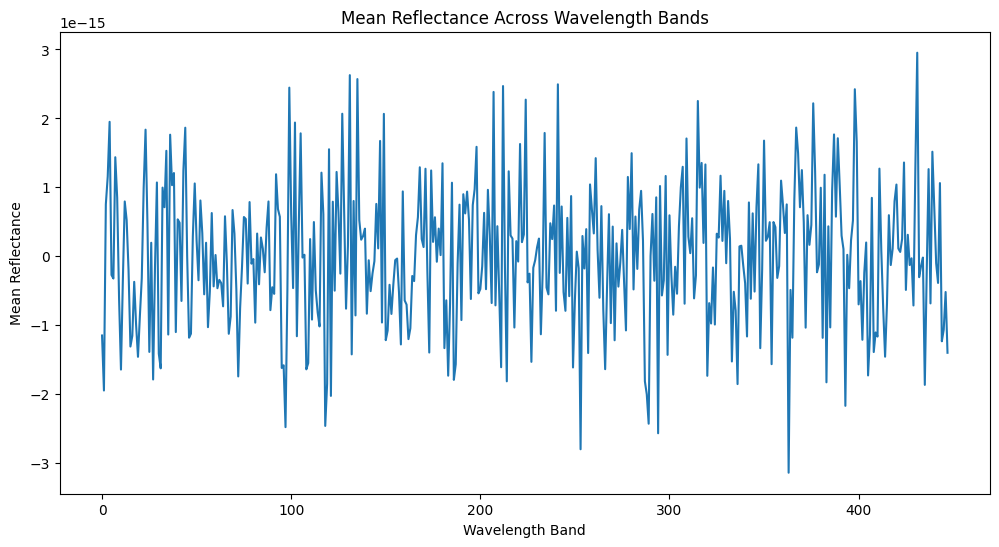

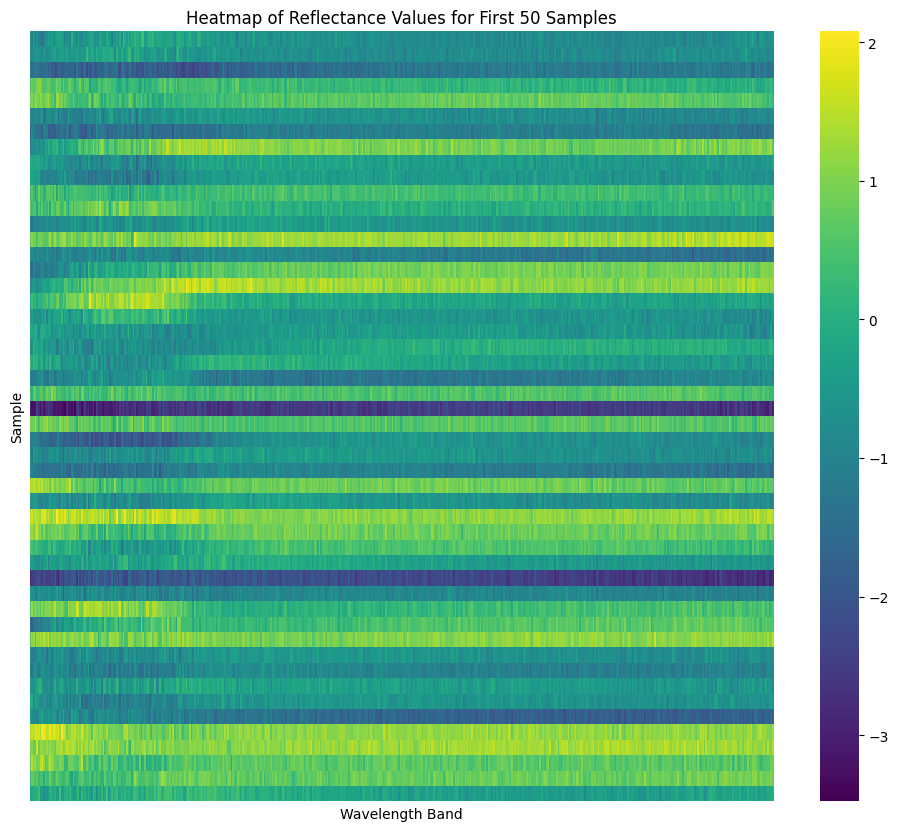

In [27]:
mean_reflectance = X_scaled.mean(axis=0)

plt.figure(figsize=(12, 6))
plt.plot(mean_reflectance)
plt.title('Mean Reflectance Across Wavelength Bands')
plt.xlabel('Wavelength Band')
plt.ylabel('Mean Reflectance')
plt.show()

plt.figure(figsize=(12, 10))
sns.heatmap(X_scaled[:50], cmap='viridis',
            xticklabels=False, yticklabels=False)
plt.title('Heatmap of Reflectance Values for First 50 Samples')
plt.xlabel('Wavelength Band')
plt.ylabel('Sample')
plt.show()

## Dimensionality Reduction

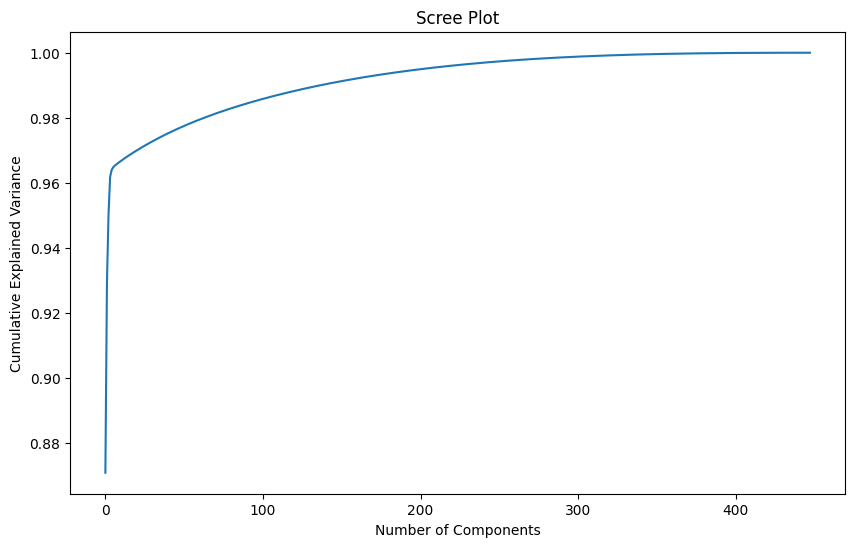


Explained Variance Ratio:
Component 1: 0.8708
Component 2: 0.0585
Component 3: 0.0211
Component 4: 0.0113
Component 5: 0.0022
Component 6: 0.0008
Component 7: 0.0005
Component 8: 0.0004
Component 9: 0.0004
Component 10: 0.0004

Number of components to retain: 3


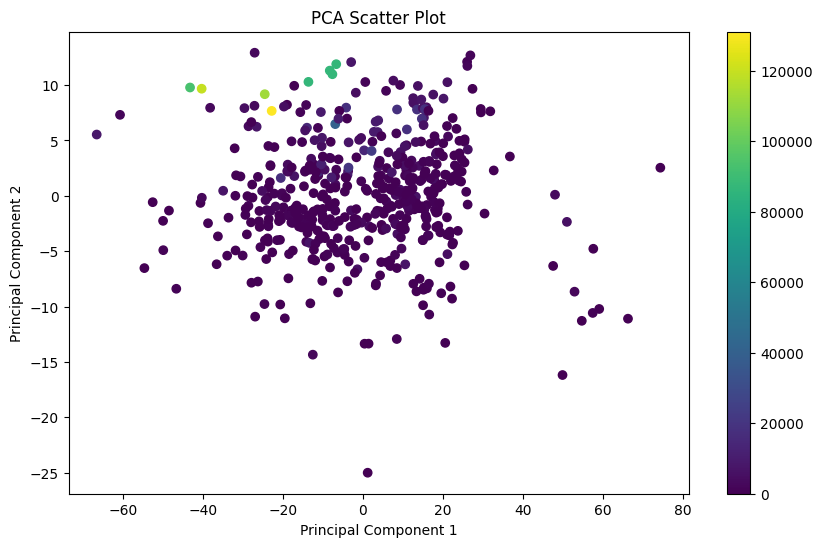

In [28]:
pca = PCA()
pca.fit(X_scaled)

explained_variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.show()

print('\nExplained Variance Ratio:')
for i, ratio in enumerate(explained_variance_ratio[:10]):
    print(f'Component {i+1}: {ratio:.4f}')

n_components = np.argmax(np.cumsum(explained_variance_ratio) >= 0.95) + 1
print(f'\nNumber of components to retain: {n_components}')

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot')
plt.colorbar()
plt.show()

### Analysing PCA Loadings

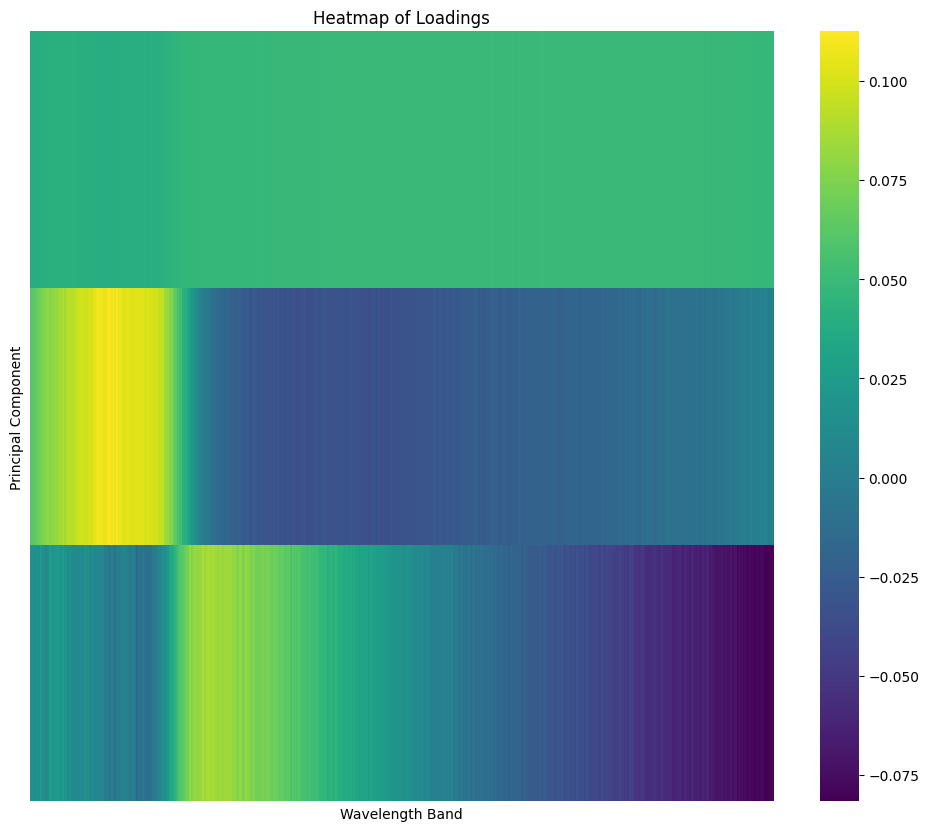


Top contributing features for PC1: [278 295 271 309 286 269 294 314 291 277]

Top contributing features for PC2: [52 47 41 48 50 43 49 46 54 42]

Top contributing features for PC3: [104 108 110 107 111 106 112 114 120 109]


In [29]:
loadings = pca.components_

plt.figure(figsize=(12, 10))
sns.heatmap(loadings, cmap='viridis', xticklabels=False, yticklabels=False)
plt.title('Heatmap of Loadings')
plt.xlabel('Wavelength Band')
plt.ylabel('Principal Component')
plt.show()

for i, component in enumerate(loadings):
    top_features = np.argsort(np.abs(component))[::-1][:10]
    print(f'\nTop contributing features for PC{i+1}: {top_features}')

## Model Training and Evaluation

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'\nMAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R-squared: {r2:.4f}')


MAE: 1798.1040
RMSE: 3751.8911
R-squared: 0.9496


## Visualizing the results

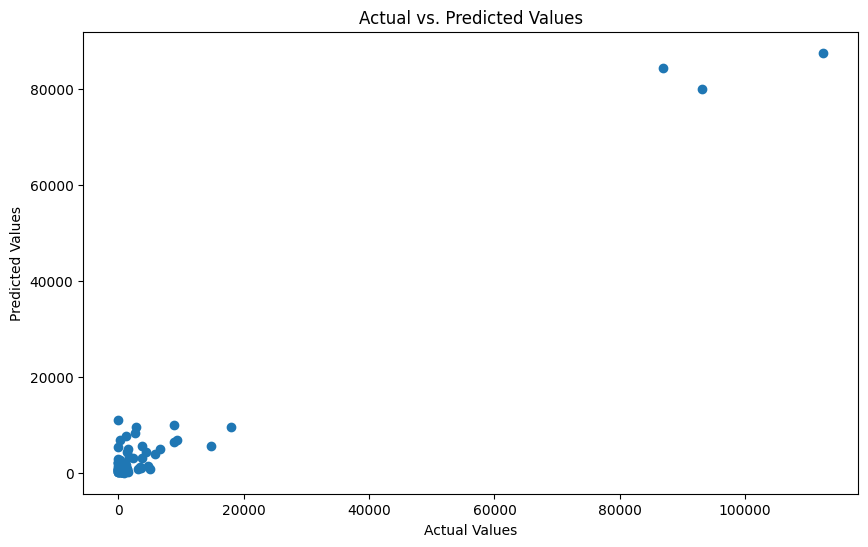

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

## Saving the Model and the scalar

In [32]:
import joblib
import os

notebook_dir = os.path.dirname(os.path.abspath("__file__"))

parent_dir = os.path.dirname(notebook_dir)

models_dir = os.path.join(parent_dir, 'models')

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

joblib.dump(model, os.path.join(models_dir, 'RF_Model.joblib'))

joblib.dump(scaler, os.path.join(models_dir, 'Scaler.joblib'))

joblib.dump(pca, os.path.join(models_dir, 'PCA.joblib'))

print(f"Model, scaler, and PCA saved successfully to: {models_dir}")

Model, scaler, and PCA saved successfully to: d:\Projects\ImagoAI-Machine-Learning-Intern-Task\models


## Conclusion
This notebook demonstrates a complete workflow for analyzing hyperspectral data to predict mycotoxin levels. The steps include data loading and preprocessing, exploratory data analysis, dimensionality reduction using PCA, and model training with a Random Forest Regressor. The visualizations and evaluation metrics provide insights into the data and the model's performance.